In [1]:
import openai
import time
import re
import requests
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from dotenv import load_dotenv
from sklearn.metrics import accuracy_score, f1_score, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load API key and endpoint info from Azure AI
load_dotenv()
openai.api_type = "azure"
openai.api_version = "2023-05-15" 
openai.api_base = os.getenv("ENDPOINT")  
openai.api_key = os.getenv("KEY1")

In [3]:
df = pd.read_csv('../../data/phmrc/phmrc_adult_tokenized.csv')

In [4]:
label_to_score = {
    'aids-tb': 0,
    'communicable': 1,
    'external': 2,
    'maternal': 3, 
    'non-communicable': 4
}

score_to_label = {
    0: 'aids-tb',
    1: 'communicable',
    2: 'external',
    3: 'maternal',
    4: 'non-communicable' 
}

In [5]:
def get_embedding(label: str) -> float:
    label = label.lower()
    if label not in label_to_score:
        print(label)
        return 0
    return label_to_score[label]

In [6]:
prompt_template = """
<narrative>
INPUT
</narrative>

<labels>
aids-tb: Patient died resulting from HIV-AIDs or Tuberculosis.
communicable: Patient died from a communicable disease which is defined as 
illnesses that spread from one human to another such as pneumonia, diarrhea 
or dysentery.
external: Patient died from external causes including as accidents like fires,
drowning, road traffic, falls, poisonous animals and violence like suicide, 
homicide, or other injuries.
maternal: Patient died from complications related to pregnancy or childbirth 
including from severe bleeding, sepsis, pre-eclampsia and eclampsia.
non-communicable: Patient died from a non-communicable disease which is defined
as illnesses that cannot be transmitted from one human to another such as cirrhosis,
epilepsy, acute myocardial infarction, copd, renal failure, cancer, diabetes,
stroke, malaria, asthma, or other non-communicable diseases.
</labels>

<options>
aids-tb, 
communicable, 
external, 
maternal, 
non-communicable
</options>


Which label best applies applies to the narrative (aids-tb, communicable, external, maternal, non-communicable)?
Limit your response to one of the options exactly as it appears in the list.
"""

# remove \n
prompt_template = prompt_template.replace('\n', '')

In [7]:
def inspect_narrative(row):
    print('Narrative: ' + df['narrative'][row])
    print('True Label: ' + df['gs_text34'][row])
    print('Broad Category: ' + df['gs_cod'][row])
    print('Embedding Representation: ' + str(label_to_score[df['gs_cod'][row]]))

In [116]:
inspect_narrative(100)

Narrative: the respondent explained that the deceased's intestine was damaged and it developed some leakage (perforation), was operated but unfortunalely it was not successful and led to the death.
True Label: other non-communicable diseases
Broad Category: non-communicable
Embedding Representation: 4


# Test it on a single example

In [117]:
# try by inputting a specific text narrative
text = df['narrative'][100]

# call model
response = None
while response is None:
    try:
        response = openai.ChatCompletion.create(
        engine="gpt-4-32k", # deployment name on openAI Azure
        messages=[
                {"role": "user", "content": prompt_template.replace("INPUT", text)}
            ],
        temperature=0
        )
    except Exception as e:
        print(e)
        time.sleep(1)
        
score = get_embedding(response["choices"][0]["message"]["content"])
print(response["choices"][0]["message"]["content"])
print(score)

non-communicable
4


# Zero Shot Prediction on all data.

In [35]:
# run all narratives

zeroshot_predictions = []

for narrative in tqdm(df['narrative']):
    # call model
    response = None
    while response is None:
        try:
            response = openai.ChatCompletion.create(
            engine="gpt-4-32k", # deployment name on openAI Azure
            messages=[
                    {"role": "user", "content": prompt_template.replace("INPUT", narrative)}
                ],
            temperature=0
            )
        except Exception as e:
            print(e)
            time.sleep(1)

    score = response["choices"][0]["message"]["content"]
    zeroshot_predictions.append(score)

 16%|█████▉                               | 1078/6763 [23:35<2:13:58,  1.41s/it]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 17%|█████▊                             | 1124/6763 [1:56:43<2:39:30,  1.70s/it]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 20%|███████                            | 1358/6763 [2:12:37<1:29:20,  1.01it/s]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 21%|███████▎                           | 1408/6763 [2:24:08<2:51:43,  1.92s/it]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 23%|████████▏                          | 1584/6763 [3:06:58<1:38:27,  1.14s/it]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 26%|█████████                          | 1758/6763 [3:20:38<1:49:10,  1.31s/it]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 27%|█████████▍                         | 1829/6763 [3:32:25<1:54:27,  1.39s/it]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 61%|██████████████████████▍              | 4099/6763 [4:30:10<40:47,  1.09it/s]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 82%|██████████████████████████████▍      | 5553/6763 [5:12:50<15:44,  1.28it/s]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 84%|███████████████████████████████▏     | 5706/6763 [5:25:32<17:28,  1.01it/s]

Error communicating with OpenAI: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


100%|█████████████████████████████████████| 6763/6763 [5:48:19<00:00,  3.09s/it]


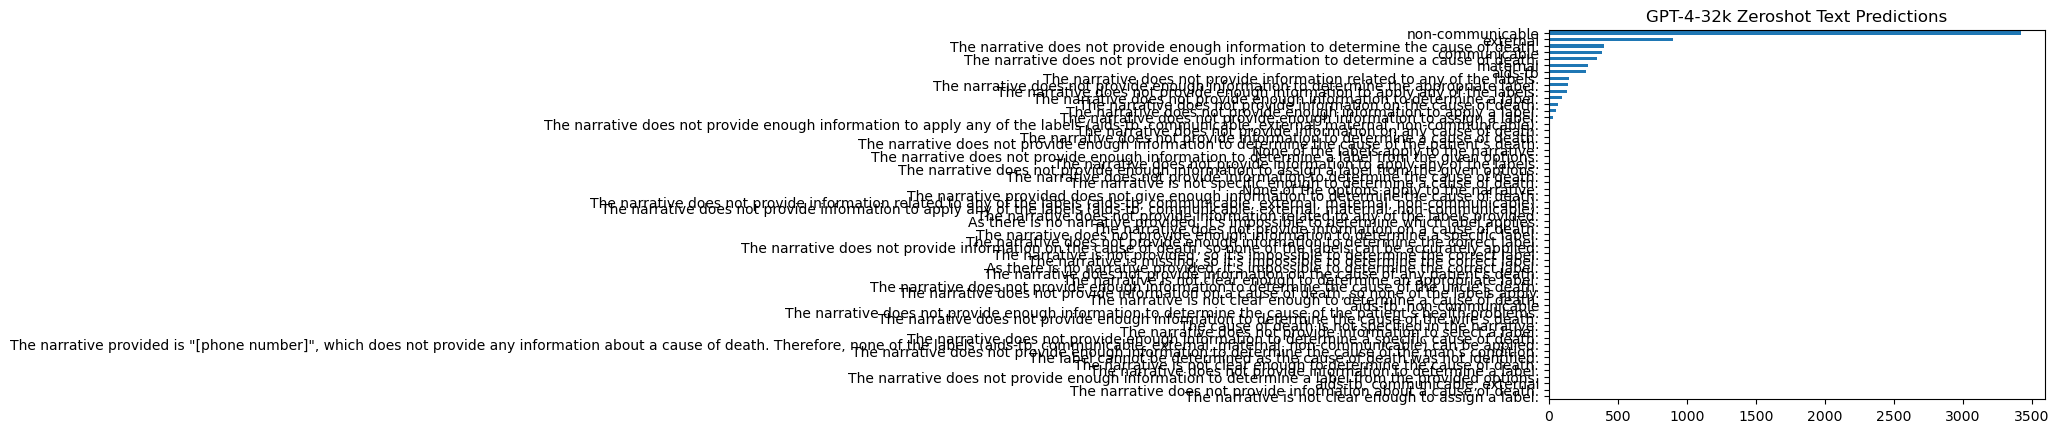

In [36]:
pd.Series(zeroshot_predictions).value_counts().plot.barh(title='GPT-4-32k Zeroshot Text Predictions').invert_yaxis()

In [37]:
# get embeddings for text predictions. If prediction not in list, use 'non-communicable'
cod_list = ['aids-tb', 'communicable', 'external', 'maternal', 'non-communicable']
zeroshot_scores = [get_embedding(x) if x in cod_list else get_embedding('non-communicable') for x in zeroshot_predictions]

In [38]:
# write out to csv
pd.Series(zeroshot_predictions).to_csv("gpt4-32k_zeroshot_text.csv", index=False)
pd.Series(zeroshot_scores).to_csv("gpt4-32k_zeroshot_score.csv", index=False)

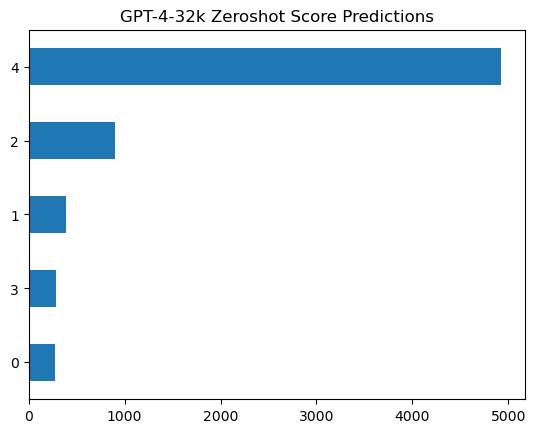

In [40]:
# plot scores distribution
pd.Series(zeroshot_scores).value_counts().plot.barh(title='GPT-4-32k Zeroshot Score Predictions').invert_yaxis()

## Few Shot Prediction on all data

In [92]:
# Define a function to perform the random sampling within each group
def random_sample(group):
    return group.sample(n)

In [109]:
# function to take in dataframe and output fewshot prompting examples in JSON format
def make_fewshot_examples(input_df, n, leave_out = ''):
    '''
    input_df :: pandas dataframe
    obs :: integer value number of observations for each site/COD permutation
    leave_out :: string for which site to leave out of the data frame for sampling
    This function takes a random subset of size obs from df subset for each site and COD category
    creates a user/assistant prompt example from the 'gs_cod' and 'narrative' columns
    returns all few shot examples as a list of dictionaries
    leave_out defaults to not excluding any sites
    '''
    
    # subset inpute df to to all 5/6 sites other than leave_out
    exclude_df = input_df[input_df['site'] != leave_out]
    
    # Apply the sample function to each group defined by 'site' and 'gs_cod'
    subset_df = exclude_df.groupby(['site', 'gs_cod'], group_keys=False).apply(random_sample)
    
    # Reset index
    subset_df.reset_index(drop=True, inplace=True)
    
#     # output plots of COD or SITE distributions
#     subset_df['gs_cod'].value_counts().plot(kind='barh', title='COD Distribution for Subsample')
#     subset_df['site'].value_counts().plot(kind='barh', title='Site Distribution for Subsample')

    
    messages = []
    
    for i, narratives in tqdm(subset_df.iterrows()):
        narrative = narratives['narrative']
        label = narratives['gs_cod']
        
        messages.append({"role": "user", "content": narrative})
        messages.append({"role": "assistant", "content": label})
    
    print('Number of User/Assistant Pairs: ' + str(len(messages)/2))
    return messages

In [111]:
# select few shot examples
random.seed(1)
fewshot_examples = make_fewshot_examples(df, 50)

60it [00:00, 13655.56it/s]

Number of User/Assistant Pairs: 60.0


In [20]:
# run all narratives

fewshot_predictions = []

for narrative in tqdm(df['narrative']):
    # call model
    response = None
    while response is None:
        try:
            response = openai.ChatCompletion.create(
            engine="gpt-4-32k", # deployment name on openAI Azure
            messages=fewshot_examples + [{"role": "user", "content": prompt_template.replace("INPUT", narrative)}],
            temperature=0
            )
        except Exception as e:
            print(e)
            time.sleep(1)

    score = response["choices"][0]["message"]["content"]
    fewshot_predictions.append(score)

100%|███████████████████████████████████████| 6763/6763 [45:24<00:00,  2.48it/s]


In [21]:
# convert text to scores
fewshot_scores = [get_embedding(x) if x in cod_list else get_embedding('non-communicable') for x in fewshot_predictions]

# write out to csv
pd.Series(fewshot_predictions).to_csv("gpt35_fewshot_text.csv", index=False)
pd.Series(fewshot_scores).to_csv("gpt35_fewshot_score.csv", index=False)

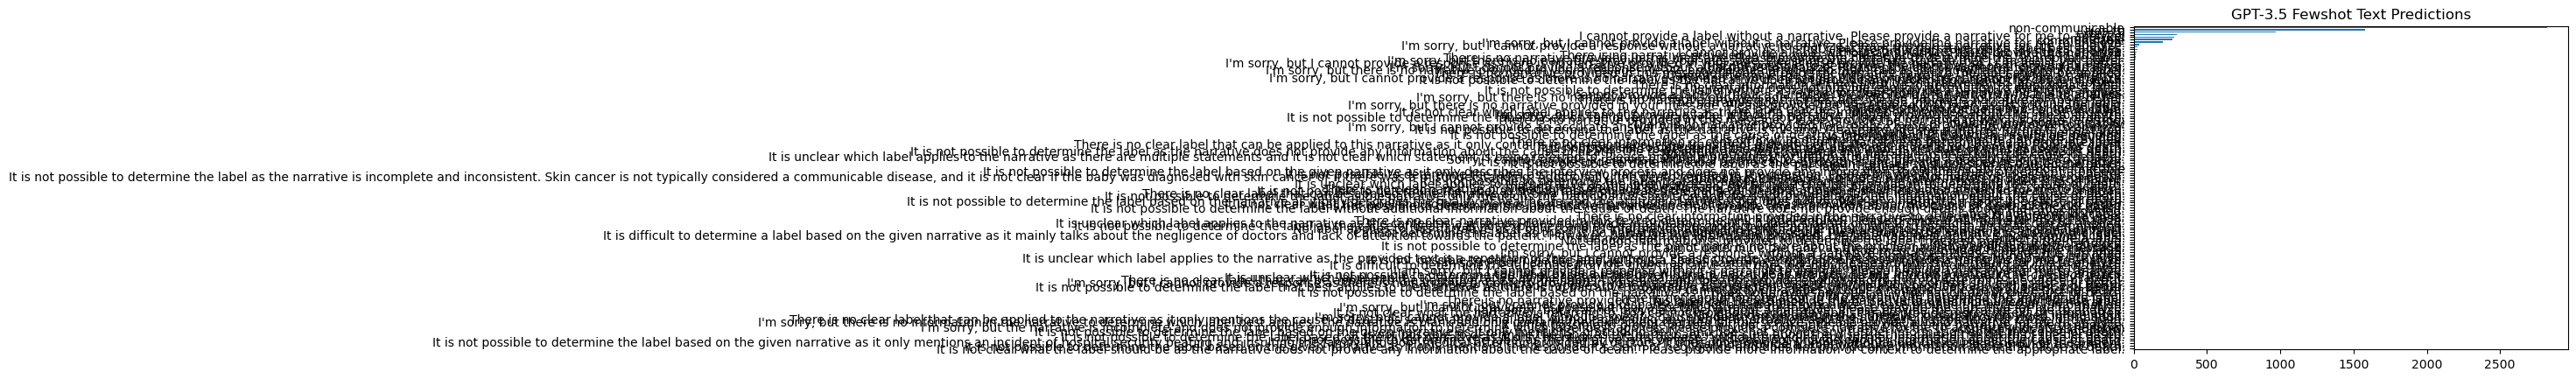

In [22]:
# plot text score dist
pd.Series(fewshot_predictions).value_counts().plot.barh(title='GPT-3.5 Fewshot Text Predictions').invert_yaxis()

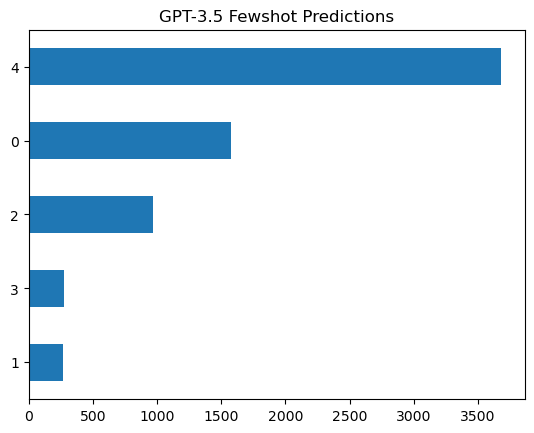

In [23]:
# plot text score dist
pd.Series(fewshot_scores).value_counts().plot.barh(title='GPT-3.5 Fewshot Predictions').invert_yaxis()

## Compute and Compare Accuracy

In [41]:
predictions_classic = pd.read_csv('../classic_nlp/baseline_predictions.csv')
# predictions_bert = pd.read_csv('../transformer_nlp/ansformer_nlp/predictions_bert.csv')
predictions_gtp35_zeroshot = pd.read_csv('gpt35_zeroshot_score.csv')
predictions_gtp35_fewshot = pd.read_csv('gpt35_fewshot_score.csv')
predictions_gpt432k_zeroshot = pd.read_csv('gpt4-32k_zeroshot_score.csv')

In [47]:
accuracy_df = predictions_classic.copy()
# accuracy_df['predictions_BERT'] = predictions_bert
accuracy_df['predictions_GPT35_zeroshot'] = predictions_gtp35_zeroshot
accuracy_df['predictions_GPT35_fewshot'] = predictions_gtp35_fewshot
accuracy_df['predictions_GPT4-32k_zeroshot'] = predictions_gpt432k_zeroshot


accuracy_df = accuracy_df.rename(columns={"predictions_NB": "NB", 
                            "predictions_SVM": "SVM", 
                            "predictions_KNN": "KNN",
                            "predictions_GPT35_zeroshot": "GPT35_zeroshot",
                            "predictions_GPT35_fewshot": "GPT35_fewshot",
                            "predictions_GPT4-32k_zeroshot": "GPT4-32k_zeroshot"})

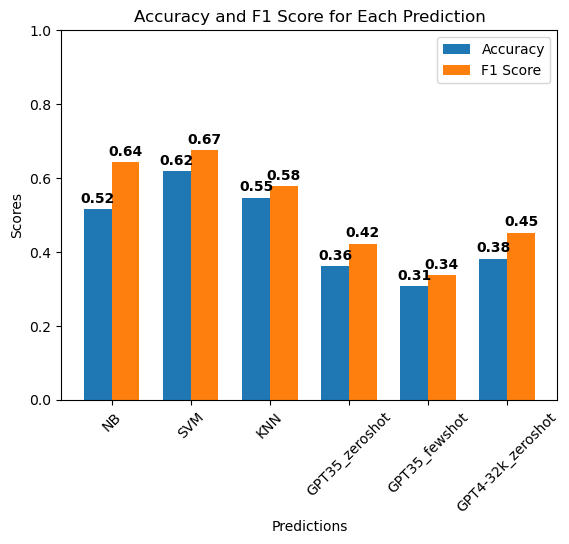

In [48]:
# Calculate accuracy and F1 score for each prediction column
columns_to_evaluate = ['NB', 'SVM', 'KNN', 'GPT35_zeroshot', 'GPT35_fewshot', 'GPT4-32k_zeroshot']
accuracy_scores = []
f1_scores = []

for column in columns_to_evaluate:
    accuracy = accuracy_score(accuracy_df[column], accuracy_df['Test_Y'])
    f1 = f1_score(accuracy_df[column], accuracy_df['Test_Y'] , average = 'weighted')
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

# Plot the results
fig, ax = plt.subplots()

bar_width = 0.35
index = np.arange(len(columns_to_evaluate))

bar1 = ax.bar(index, accuracy_scores, bar_width, label='Accuracy')
bar2 = ax.bar(index + bar_width, f1_scores, bar_width, label='F1 Score')

ax.set_xlabel('Predictions')
ax.set_ylabel('Scores')
ax.set_title('Accuracy and F1 Score for Each Prediction')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(columns_to_evaluate)
plt.xticks(rotation=45)
ax.legend()
# Set y-axis range to 0-1
ax.set_ylim(0, 1)

# Add scores on top of each bar
for i, (acc, f1) in enumerate(zip(accuracy_scores, f1_scores)):
    ax.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom', color='black', fontweight='bold')
    ax.text(i + bar_width, f1 + 0.01, f'{f1:.2f}', ha='center', va='bottom', color='black', fontweight='bold')

plt.show()

In [112]:
df['predictions_gpt432k']

(6763, 12)

In [115]:
len(predictions_gpt432k_zeroshot)

6763